In [62]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
%config InlineBackend.figure_format = 'svg'

import string
import re

from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [7]:
df_main_train = pd.read_csv('nlp_train.csv', encoding='ISO-8859-1', index_col='Id')
test = pd.read_csv('nlp_test.csv', encoding='ISO-8859-1', index_col='Id')

In [8]:
df_main_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2351 entries, 0 to 2350
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Hotel_name    2351 non-null   object 
 1   Review_Title  2136 non-null   object 
 2   Review_Text   2351 non-null   object 
 3   Rating        2351 non-null   float64
dtypes: float64(1), object(3)
memory usage: 91.8+ KB


In [35]:
df = df_main_train.copy()

In [36]:
df.fillna({'Review_Title': '0'}, inplace = True)

In [37]:
negs = list(pd.read_csv('negative-words.txt', encoding='ISO-8859-1').iloc[:, 0])
poss = list(pd.read_csv('positive-words.txt', encoding='ISO-8859-1').iloc[:, 0])

In [38]:
#Почистим от лишних слов отзывы и заголовки

from nltk.corpus import stopwords
sw_eng = set(stopwords.words('english')) - set(['no', 'not'])

In [39]:
for i in tqdm(range(2351)):
    df['Review_Text'][i] = ' '.join([word for word in df['Review_Text'][i].lower().split() if not word in sw_eng])

In [40]:
for i in tqdm(range(2351)):
    df['Review_Title'][i] = ' '.join([word for word in df['Review_Title'][i].lower().split() if not word in sw_eng])

In [41]:
def cleaning_str(that_string):
    void = ''
    w = re.split(r'[;,\s.?!:-]', that_string)
    for token in w:
        if token == '':
            w.remove(token)
    w = ' '.join([word for word in w])
    return w

In [42]:
puncts = [] 
for stri in df['Review_Text']:
    for _ in stri:
        if _ in string.punctuation:
            puncts.append(_)
for stri in df['Review_Title']:
    for _ in stri:
        if _ in string.punctuation:
            puncts.append(_)
puncts = set(puncts)

In [43]:
for sep in puncts:
    df['Review_Title'] = df['Review_Title'].apply(lambda x: x.replace(sep, ""))
    df['Review_Text'] = df['Review_Text'].apply(lambda x: x.replace(sep, ""))   

In [44]:
#Посчитаю доли хороших и плохих слов в тексте отзыва

text_pos_share = []
text_neg_share = []
text_words_number = []
from tqdm.notebook import tqdm

for that_string in tqdm(df['Review_Text']):
    pos_count = 0
    neg_count = 0
    words_count = 0
    for word in that_string.split():
        if word in poss:
            pos_count += 1
        if word in negs:
            neg_count += 1
        words_count += 1
    if words_count == 0:
        text_pos_share.append(0)
        text_neg_share.append(0)
        text_words_number.append(0)
    else:
        text_pos_share.append(pos_count / words_count)
        text_neg_share.append(neg_count / words_count)
        text_words_number.append(words_count)

In [45]:
#Посчитаю доли хороших и плохих слов в заголовке отзыва

title_pos_share = []
title_neg_share = []
title_words_number = []

for that_string in tqdm(df['Review_Title']):
    pos_count = 0
    neg_count = 0
    words_count = 0
    for word in that_string.split():
        if word in poss:
            pos_count += 1
        if word in negs:
            neg_count += 1
        words_count += 1
    if words_count == 0:
        title_pos_share.append(0)
        title_neg_share.append(0)
        title_words_number.append(words_count)
    else:
        title_pos_share.append(pos_count / words_count)
        title_neg_share.append(neg_count / words_count)
        title_words_number.append(words_count)

**Прим.:** Если делать фичи "кол-во хороших/плохих слов" и "кол-во слов всего" в тексте/заголовке вместо долей, то MSE получается больше

In [46]:
df['text_pos_share'] = text_pos_share
df['text_neg_share'] = text_neg_share
df['title_pos_share'] = title_pos_share
df['title_neg_share'] = title_neg_share
df['text_words_number'] =  text_words_number
df['title_words_number'] =  title_words_number

**Лемматизация**

In [47]:
from nltk import wordnet, pos_tag
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN

In [48]:
from nltk import WordNetLemmatizer
def my_lemmatizer(sent):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sent.split()
    pos_tagged = [(word, get_wordnet_pos(tag))
                 for word, tag in pos_tag(tokenized_sent)]
    return ' '.join([lemmatizer.lemmatize(word, tag)
                    for word, tag in pos_tagged])

In [49]:
df['Review_Text']=df['Review_Text'].apply(lambda x: my_lemmatizer(x))
df['Review_Title']=df['Review_Title'].apply(lambda x: my_lemmatizer(x))

In [50]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
df['Hotel_name'] = le.fit_transform(df['Hotel_name'])

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [52]:
X = df.drop(['Rating', 'title_words_number','text_words_number' ], axis=1)
y = df['Rating']

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
X_train

,Hotel_name,Review_Title,Review_Text,text_pos_share,text_neg_share,title_pos_share,title_neg_share
Id,,,,,,,
1547,141,clean big room,arrive late night thailand look forward drink ...,0.137931,0.103448,0.333333,0.000000
1917,163,low price hotel high quality,notice many change hotel check process smooth ...,0.162162,0.000000,0.000000,0.000000
543,235,bad place stay,many mosquito late check in warm room fridge n...,0.070175,0.070175,0.000000,0.333333
1535,55,near place go engag,stay hotel comfortable transport easily available,0.333333,0.000000,0.000000,0.000000
494,188,overall good stay clean room,stay good overall stay three day location good...,0.384615,0.000000,0.400000,0.000000
...,...,...,...,...,...,...,...
1638,57,poor maintenance,room look like old small poorly maintain found...,0.085714,0.057143,0.000000,0.500000
1095,216,0,great experience really good hotel professiona...,0.333333,0.000000,0.000000,0.000000
1130,170,average stay,hotel locate within 1 km chennai central stati...,0.040000,0.040000,0.000000,0.000000


Не буду лукавить, код с пайпланами **взял** у Никиты, который давеча делился ноутбуком по этой домашке на каггле. Просто у меня ни в какую не хотели модели работать с преобразованными по **TF-IDF** текстами, выходило вот такое и модель ругалась на **это**:

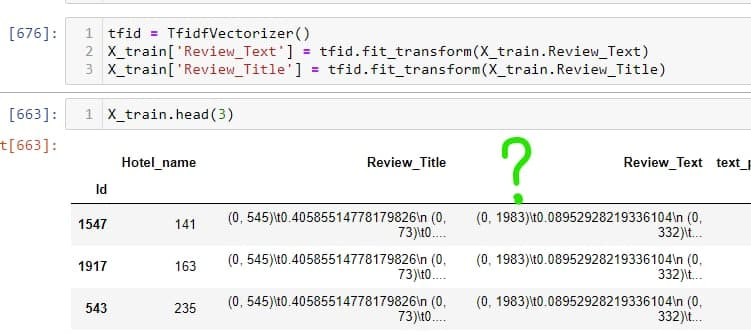

In [55]:
from IPython.display import Image
Image(filename='trouble.jpg')

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [57]:
text1 = Pipeline([
                ('selector', TextSelector(key='Review_Text')),
                ('counter', TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000, ngram_range=(1, 1)))
            ])

text1.fit_transform(X_train)

text2 = Pipeline([
                ('selector', TextSelector(key='Review_Title')),
                ('counter', TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000, ngram_range=(1, 3)))
            ])

text2.fit_transform(X_train)

<1763x3857 sparse matrix of type '<class 'numpy.float64'>'
	with 10931 stored elements in Compressed Sparse Row format>

In [58]:
text_pos_share =  Pipeline([
                ('selector', NumberSelector(key='text_pos_share')),
                ('standard', StandardScaler())
            ])

text_neg_share =  Pipeline([
                ('selector', NumberSelector(key='text_neg_share')),
                ('standard', StandardScaler())
            ])

title_pos_share =  Pipeline([
                ('selector', NumberSelector(key='title_pos_share')),
                ('standard', StandardScaler())
            ])

title_neg_share =  Pipeline([
                ('selector', NumberSelector(key='title_neg_share')),
                ('standard', StandardScaler())
            ])

In [59]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion([('Review_Title', text1), 
                      ('Review_Text', text2),
                     ('text_pos_share', text_pos_share),
                     ('text_neg_share', text_neg_share),
                     ('title_pos_share', title_pos_share),
                     ('title_neg_share', title_neg_share)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<1763x7554 sparse matrix of type '<class 'numpy.float64'>'
	with 51764 stored elements in Compressed Sparse Row format>

**Итоговый скор**

In [65]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostRegressor(verbose=False)),
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mean_squared_error(y_test, y_pred)

169.95266801917515

В чатике люди писали, что на сиде 42 mse получается ~179, у меня вышел 173,8. Я рад! Видимо, помогла более детальная обработка текста(чистил слова от точек и других знаков препинания, чтобы split() работал лучше. Пытался сплитить сразу по нескольким знакам препинания, но тогда в списке возникает '', который почему-то не хотел удаляться адекватно. Тогда он бы мог испортить мне всю статистику(кол-во слов в отзыве)